In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
from collections import Counter
import numpy as np
import missingno
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from recommenders.utils.timer import Timer
from recommenders.models.deeprec.models.graphrec.lightgcn import LightGCN
from recommenders.models.deeprec.DataModel.ImplicitCF import ImplicitCF
from recommenders.datasets import movielens
from recommenders.datasets.python_splitters import python_stratified_split
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.utils.constants import SEED as DEFAULT_SEED
from recommenders.models.deeprec.deeprec_utils import prepare_hparams
import dgl

In [3]:
!pip install recommenders

  Using cached recommenders-1.1.1-py3-none-any.whl (339 kB)
  Using cached pandas-1.5.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
  Using cached scikit_learn-1.0.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.4 MB)
  Using cached lightfm-1.17-cp39-cp39-linux_x86_64.whl
  Using cached lightgbm-4.0.0-py3-none-manylinux_2_28_x86_64.whl (3.0 MB)
  Using cached memory_profiler-0.61.0-py3-none-any.whl (31 kB)
  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 11.8 MB/s eta 0:00:0000:0100:01
  Using cached category_encoders-1.3.0-py2.py3-none-any.whl (61 kB)
  Using cached Jinja2-3.0.3-py3-none-any.whl (133 kB)
  Using cached PyYAML-5.4.1-cp39-cp39-manylinux1_x86_64.whl (630 kB)
  Using cached cornac-1.15.4-cp39-cp39-manylinux1_x86_64.whl (18.8 MB)
  Using cached retrying-1.3.4-py3-none-any.whl (11 kB)
  Using cached pandera-0.16.1-py3-none-any.whl (201 kB)
  Using cached scikit_surprise-1.1.3-c

In [3]:
pip install missingno

  Using cached missingno-0.5.2-py3-none-any.whl (8.7 kB)
Note: you may need to restart the kernel to use updated packages.


In [7]:
# cold_data_3= pd.read_csv("cold_data_0.3.csv")
# cold_data_7= pd.read_csv("cold_data_0.7.csv")
# cold_data_1= pd.read_csv("cold_data_1.csv")
# cold_data= pd.read_csv("cold_data.csv")
ctr_data_1M = pd.read_csv('ctr_data_1M.csv')
# sbr_data_1M = pd.read_csv('sbr_data_1M.csv')
# QB_article = pd.read_csv('QB-article.csv')
# QB_video = pd.read_csv('QB-video.csv')

# print(f"QB_article dataset has {QB_article.shape[0]} samples and {QB_article.shape[1]} features.")
# print(f"QB_video dataset has {QB_video.shape[0]} samples and {QB_video.shape[1]} features.")
print(f"ctr_data_1M dataset has {ctr_data_1M.shape[0]} samples and {ctr_data_1M.shape[1]} features.")
# print(f"sbr_data_1M dataset has {sbr_data_1M.shape[0]} samples and {sbr_data_1M.shape[1]} features.")
# print(f"cold_data dataset has {cold_data.shape[0]} samples and {cold_data.shape[1]} features.")

ctr_data_1M dataset has 120342306 samples and 20 features.


In [8]:
print(ctr_data_1M.info())
ctr_data_1M.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120342306 entries, 0 to 120342305
Data columns (total 20 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   user_id         int64 
 1   item_id         int64 
 2   click           int64 
 3   follow          int64 
 4   like            int64 
 5   share           int64 
 6   video_category  object
 7   watching_times  int64 
 8   gender          int64 
 9   age             int64 
 10  hist_1          int64 
 11  hist_2          int64 
 12  hist_3          int64 
 13  hist_4          int64 
 14  hist_5          int64 
 15  hist_6          int64 
 16  hist_7          int64 
 17  hist_8          int64 
 18  hist_9          int64 
 19  hist_10         int64 
dtypes: int64(19), object(1)
memory usage: 17.9+ GB
None


,user_id,item_id,click,follow,like,share,watching_times,gender,age,hist_1,hist_2,hist_3,hist_4,hist_5,hist_6,hist_7,hist_8,hist_9,hist_10
count,1.203423e+08,1.203423e+08,1.203423e+08,1.203423e+08,1.203423e+08,1.203423e+08,1.203423e+08,1.203423e+08,1.203423e+08,1.203423e+08,1.203423e+08,1.203423e+08,1.203423e+08,1.203423e+08,1.203423e+08,1.203423e+08,1.203423e+08,1.203423e+08,1.203423e+08
mean,4.589467e+05,5.484934e+05,2.399893e-01,1.493972e-03,1.890787e-02,2.078147e-03,8.046658e-01,1.044012e+00,2.032055e+00,2.315439e+05,2.313367e+05,2.345104e+05,2.367993e+05,2.384987e+05,2.392605e+05,2.379480e+05,2.355462e+05,2.316875e+05,2.281974e+05
std,2.837788e+05,7.866086e+05,4.270766e-01,3.862305e-02,1.361997e-01,4.553930e-02,1.025738e+00,6.465168e-01,1.228040e+00,4.530797e+05,4.568149e+05,4.592573e+05,4.609707e+05,4.622699e+05,4.631671e+05,4.624645e+05,4.615630e+05,4.590176e+05,4.584830e+05
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.103520e+05,1.059600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,4.660000e+03,4.190000e+03,4.372000e+03,4.564000e+03,4.604000e+03,4.605000e+03,4.574000e+03,4.467000e+03,4.331000e+03,4.190000e+03
50%,4.424570e+05,7.689500e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.403200e+04,2.130600e+04,2.212000e+04,2.293700e+04,2.345000e+04,2.360800e+04,2.337300e+04,2.266100e+04,2.211600e+04,2.167000e+04
75%,6.914810e+05,1.354503e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,1.341320e+05,1.289420e+05,1.346650e+05,1.393970e+05,1.431950e+05,1.435480e+05,1.435370e+05,1.411130e+05,1.370500e+05,1.327790e+05
max,1.000016e+06,3.864722e+06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.055000e+03,2.000000e+00,7.000000e+00,1.785924e+06,3.807006e+06,3.807007e+06,3.807008e+06,3.807009e+06,3.827799e+06,3.857340e+06,3.807012e+06,3.807013e+06,3.818602e+06


In [9]:
ctr_data_1M.head()

,user_id,item_id,click,follow,like,share,video_category,watching_times,gender,age,hist_1,hist_2,hist_3,hist_4,hist_5,hist_6,hist_7,hist_8,hist_9,hist_10
0,1,4,0,0,0,0,1,0,1,4,2,3,80936,781,111774,1230,26403,991,2362,1202
1,1,1201,1,0,0,0,1,1,1,4,2,3,80936,781,111774,1230,26403,991,2362,1202
2,1,250502,1,0,0,0,1,1,1,4,2,3,80936,781,111774,1230,26403,991,2362,1202
3,1,50885,1,0,0,0,1,1,1,4,2,3,80936,781,111774,1230,26403,991,2362,1202
4,1,16934,1,0,0,0,0,1,1,4,2,3,80936,781,111774,1230,26403,991,2362,1202


In [10]:
ctr_data_1M.tail()

,user_id,item_id,click,follow,like,share,video_category,watching_times,gender,age,hist_1,hist_2,hist_3,hist_4,hist_5,hist_6,hist_7,hist_8,hist_9,hist_10
120342301,1000016,1362512,0,0,0,0,0,0,0,0,1369883,1352693,1354406,146944,1352546,1354871,1355320,1359738,1365339,0
120342302,1000016,1377187,0,0,0,0,0,0,0,0,1369883,1352693,1354406,146944,1352546,1354871,1355320,1359738,1365339,0
120342303,1000016,1353565,0,0,0,0,0,1,0,0,1369883,1352693,1354406,146944,1352546,1354871,1355320,1359738,1365339,0
120342304,1000016,23121,0,0,0,0,1,1,0,0,1369883,1352693,1354406,146944,1352546,1354871,1355320,1359738,1365339,0
120342305,1000016,9150,0,0,0,0,1,1,0,0,1369883,1352693,1354406,146944,1352546,1354871,1355320,1359738,1365339,0


### Check data quality for missing values.

In [11]:
def missing_info(dataset):
  # count the ratio of missing values
  total_miss = dataset.isnull().sum()
  if dataset.isna().values.any() == True:
    #this condidtion will be evaluated.
    print(f"There are {total_miss} missing values in this dataset.")
    plot_missing(dataset)
    percent_miss = (total_miss/dataset.isnull().count()*100)
    # sort attributes by missing value ratio
    missing_data = pd.DataFrame({'Total missing':total_miss,'% missing':percent_miss})
    missing_data.sort_values(by='Total missing',ascending=False)
    return missing_data
  else:
    return "There are no missing values in this dataset."

### Check data quality for outliers.

In [12]:
#find the outlier 
def find_outliers(column):
   sns.set_theme(style="whitegrid")
   sns.set(rc={'figure.figsize':(15,6)})
   founded_outlier = sns.boxplot(x=column)
   founded_outlier.set(title = "Founded feature with outliers")

### Plot missings graphs

In [13]:
#analyzing missing data
def plot_missing(dataset):
  #bar chart
  missingno.bar(dataset)
  #visualize missing values as a matrix
  missingno.matrix(dataset)
  #heapmap for correlation analysis
  missingno.heatmap(dataset)
  #dendrogram plot
  #missingno.dendrogram(dataset)

### Plot distribution a numerical feature.

In [14]:
def distribution_of_feature(df,dataset_name,feature_name):
    plt.figure(figsize=(20,10))
    dist = sns.displot(data = df, kde=True)
    fig_title = f"distribution of {feature_name} in {dataset_name}"
    dist.set(title = fig_title)

In [15]:
ctr_data_1M_missing = missing_info(ctr_data_1M)
ctr_data_1M_missing

'There are no missing values in this dataset.'

In [16]:
if ctr_data_1M.duplicated().any()== True:
    print(f"There are {ctr_data_1M.duplicated(keep='first').sum()} consistant duplicated values in ctr_data_1M.csv")
    ctr_data_1M.drop_duplicates(inplace = True)
    ctr_data_1M.reset_index(drop=True, inplace=True)
    
else:
    print(f"There aren't any consistant duplicated values in ctr_data_1M.csv")

KeyboardInterrupt: 

In [ ]:
if ctr_data_1M.duplicated().any()== True:
    print(f"There are {ctr_data_1M.duplicated(keep='first').sum()} consistant duplicated values in ctr_data_1M.csv")
    ctr_data_1M.drop_duplicates(inplace = True)
    ctr_data_1M.reset_index(drop=True, inplace=True)
    
else:
    print(f"There aren't any consistant duplicated values in ctr_data_1M.csv")

In [21]:
ctr_data_1M.shape

(119458660, 20)

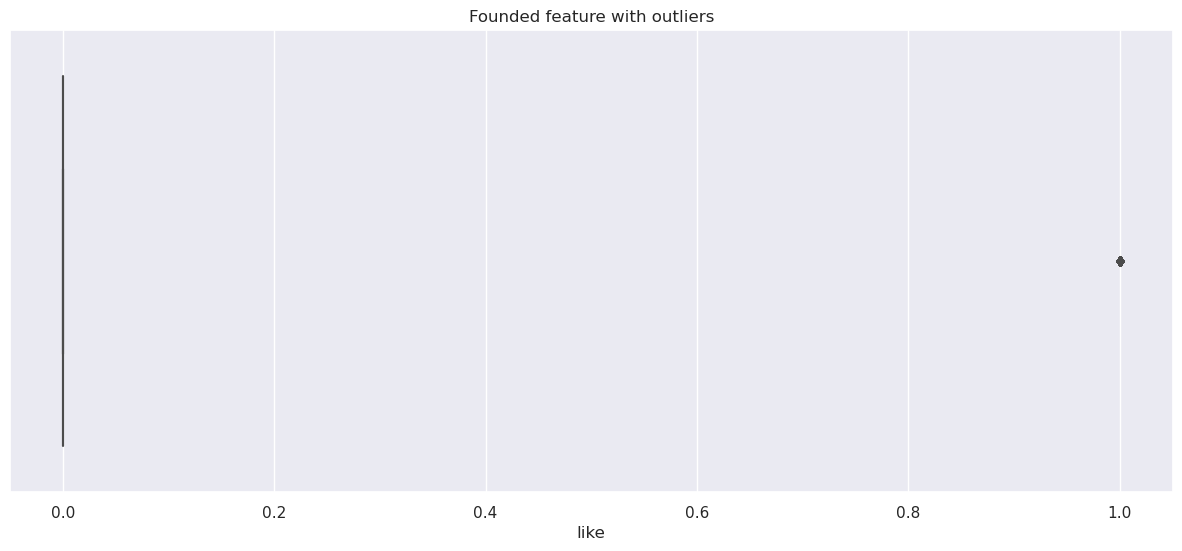

In [22]:
find_outliers(ctr_data_1M['like'])

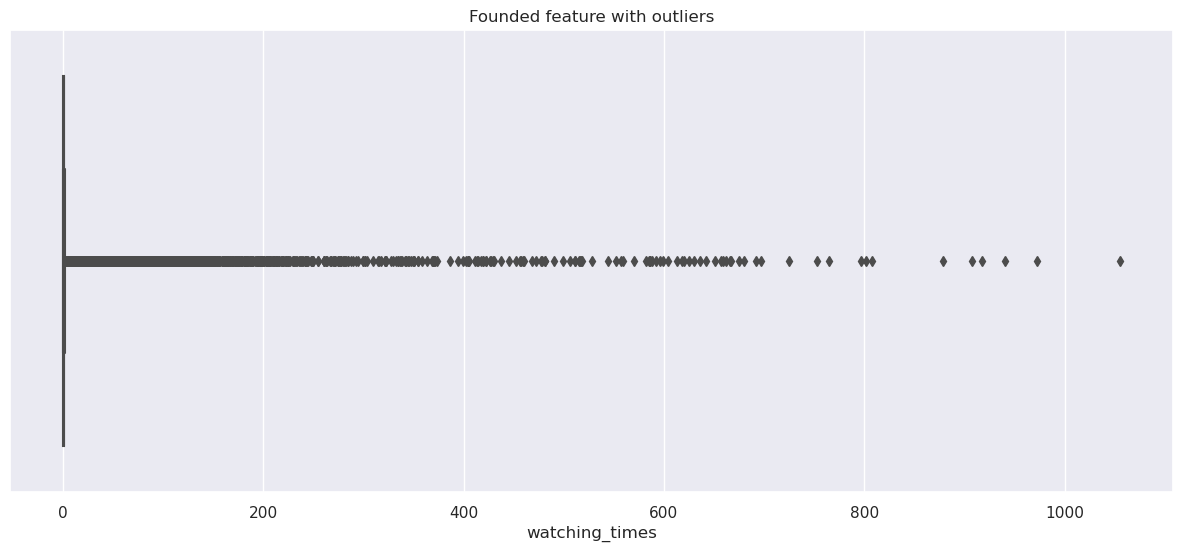

In [24]:
find_outliers(ctr_data_1M['watching_times'])

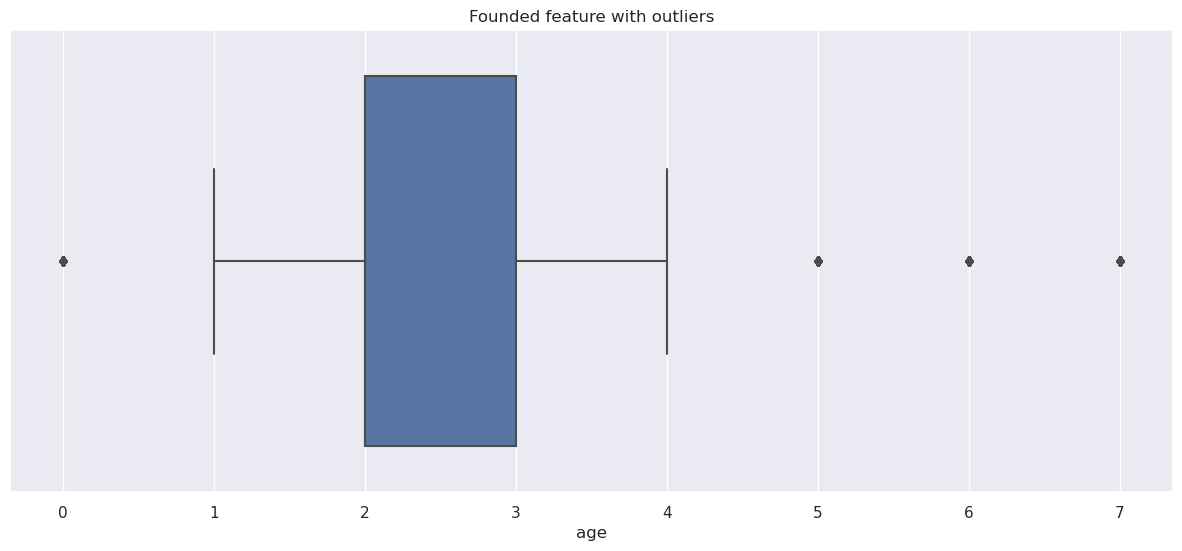

In [25]:
find_outliers(ctr_data_1M['age'])

<Figure size 2000x1000 with 0 Axes>

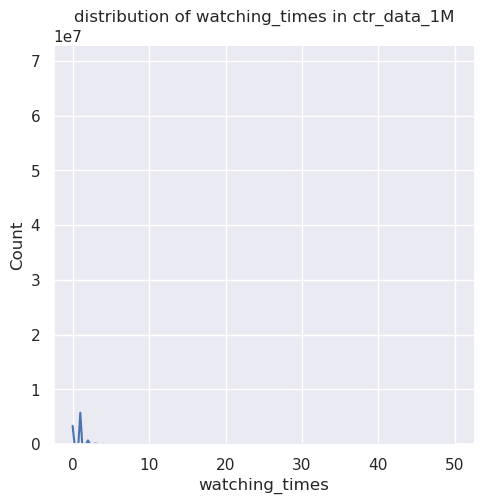

In [31]:
distribution_of_feature(ctr_data_1M['watching_times'][ctr_data_1M['watching_times'] <= 50],'ctr_data_1M','watching_times')

In [32]:
ctr_data_1M.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119458660 entries, 0 to 119458659
Data columns (total 20 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   user_id         int64 
 1   item_id         int64 
 2   click           int64 
 3   follow          int64 
 4   like            int64 
 5   share           int64 
 6   video_category  object
 7   watching_times  int64 
 8   gender          int64 
 9   age             int64 
 10  hist_1          int64 
 11  hist_2          int64 
 12  hist_3          int64 
 13  hist_4          int64 
 14  hist_5          int64 
 15  hist_6          int64 
 16  hist_7          int64 
 17  hist_8          int64 
 18  hist_9          int64 
 19  hist_10         int64 
dtypes: int64(19), object(1)
memory usage: 17.8+ GB


In [35]:
ctr_data_1M['click'].unique()

array([0, 1])

In [39]:
ctr_data_1M['video_category'].unique()

array(['1', '0', '\\N'], dtype=object)

In [40]:
ctr_data_1M['watching_times'].unique()

array([   0,    1,    2,    3,    5,    4,    7,    8,    9,    6,   29,
         20,   12,   22,   11,   33,   13,   59,   28,   14,   17,   10,
         15,   21,  108,   19,   24,  148,   16,   26,   25,   40,   31,
        135,  100,   51,  112,  130,   30,   47,   32,   58,   35,   44,
         23,   18,   41,   37,   49,   74,   75,   45,  386,   81,   69,
         61,   38,   73,   39,   27,   42,   46,  167,  138,   63,   34,
         52,   68,   50,   65,   54,   85,   36,   53,   88,   82,  150,
         48,  156,  107,   76,   98,  146,   43,   57,  172,   64,   70,
         60,   71,   95,   89,   67,  147,   91,  118,  126,  203,  117,
         62,   56,  220,  371,  192,  140,  127,  316,  596,   79,  106,
        239,   72,  219,   66,  422,   80,  137,  102,  121,  164,  201,
        199,   55,  337,   96,   78,  165,  111,   90,  552,  302,   83,
        120,  242,  194,   99,  105,  351,   87,  129,  452,  370,  115,
        195,  570,   92,  359,  725,  592,   93,  2

In [41]:
ctr_data_1M['gender'].unique()

array([1, 2, 0])

In [47]:
ctr_data_1M['hist_10'].unique()

array([   1202,   33178,      29, ..., 1553824,   62026,  519664])

In [49]:
ctr_data_1M['video_category'].value_counts()

video_category
0     64120495
1     53754124
\N     1584041
Name: count, dtype: int64

In [12]:
ctr_data_1M =ctr_data_1M.drop(ctr_data_1M[ctr_data_1M['video_category'] == '\\N'].index)

In [20]:
ctr_data_1M['video_category'].value_counts()

video_category
0    64120495
1    53754124
Name: count, dtype: int64

In [19]:
ctr_data_1M['video_category']=ctr_data_1M['video_category'].astype('int64')

In [1]:
ctr_data_1M.to_csv('ctr_data_1M_modified.csv',index_label=False)

NameError: name 'ctr_data_1M' is not defined

In [8]:
ctr_data_1M = pd.read_csv('ctr_data_1M_modified.csv')
subset= ctr_data_1M.sample(1000)
subset.to_csv('ctr_data_1M_sample_1000.csv',index_label=False)

In [85]:
df = pd.read_csv('ctr_data_1M_sample_1000.csv',index_col=0)
df

,user_id,item_id,click,follow,like,share,video_category,watching_times,gender,age,hist_1,hist_2,hist_3,hist_4,hist_5,hist_6,hist_7,hist_8,hist_9,hist_10
97313110,764210,297,0,0,0,0,0,1,1,2,271069,122958,217340,4079,350067,44104,47,44477,20869,640407
106424495,859865,1400418,0,0,0,0,1,0,1,3,1356643,1353675,1357310,1379585,1354509,1375024,1357786,1379624,1377532,1364786
87140877,671987,11787,1,0,0,0,1,1,2,4,322088,237196,4834,5526,8980,4847,17660,1714,38697,4605
44214513,315835,18720,0,0,0,0,0,1,0,0,405256,22572,29460,42958,71735,29462,60356,11194,10917,2800
67660168,507603,91564,1,0,0,0,1,2,1,2,73278,97107,133754,193091,21321,55650,253072,73282,73283,86034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38283277,269949,1377385,1,0,0,0,0,1,1,2,382097,382098,148097,148095,382099,41918,514878,38447,4610,36520
18368733,131338,22441,0,0,0,0,1,1,1,3,70,200,268193,268194,557,8120,15146,71527,232757,140
24802910,175942,2742,1,0,0,0,0,2,1,2,3498,6769,40408,6197,300,24908,95160,120680,3682,19848
23473324,166747,106636,1,0,0,0,0,1,1,1,21496,21920,19540,1454,37748,2677,84738,59664,23125,110909


In [7]:
train_df, val_test_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=42)

In [59]:
# Create a binary feedback matrix for likes
likes_matrix = sp.csr_matrix((interactions_df['like'], (interactions_df['user_id'], interactions_df['item_id'])))

# Create a binary feedback matrix for clicks
clicks_matrix = sp.csr_matrix((interactions_df['click'], (interactions_df['user_id'], interactions_df['item_id'])))

# Split the feedback matrices into training, validation, and test sets
likes_train_val, likes_test = train_test_split(likes_matrix, test_size=0.2)
likes_train, likes_val = train_test_split(likes_train_val, test_size=0.2)
clicks_train_val, clicks_test = train_test_split(clicks_matrix, test_size=0.2)
clicks_train, clicks_val = train_test_split(clicks_train_val, test_size=0.2)

# Define the MTL LightGCN model
mtl_model = MultiTaskLightGCN(num_factors=10, num_layers=3, dropout=0.1, lr=1e-3, num_epochs=10, multitask=True, use_cuda=False)

# Fit the model on the training data
mtl_model.fit(adj_matrix=clicks_train, likes_data=likes_train, clicks_data=clicks_train, likes_val_data=likes_val, clicks_val_data=clicks_val)

# Evaluate the model on the test data
likes_pred, clicks_pred = mtl_model.predict(likes_test.indices, likes_test.indptr, clicks_test.indices, clicks_test.indptr)

AttributeError: 'MultiTaskLightGCN' object has no attribute 'num_users'

In [44]:
for i in range(2):
    matrix = feedback_matrices[i]
    print(f"Matrix {i}, shape={matrix.shape}, indices.shape={matrix.indices.shape}")

Matrix 0, shape=(638843, 3424231), indices.shape=(638,)
Matrix 1, shape=(638843, 3424231), indices.shape=(662,)


# modeling lightgcn

In [3]:
import pandas as pd
import networkx as nx


# Initialize a directed graph
G = nx.DiGraph()

# Add nodes and edges
for row in df.itertuples():
    # Adding user node
    G.add_node(f"user_{row.user_id}", gender=row.gender, age=row.age)
    
    # Adding item node
    G.add_node(f"item_{row.item_id}", video_category=row.video_category, watching_times=row.watching_times)
    
    # Adding edge for current interaction
    G.add_edge(f"user_{row.user_id}", f"item_{row.item_id}", 
               click=row.click, follow=row.follow, like=row.like, share=row.share)
    
    # Adding edges for historical interactions
    for i in range(1, 11):  # for hist_1 to hist_10
        hist_item = getattr(row, f"hist_{i}")
        if pd.notna(hist_item):  # Ignore if history data is missing
            G.add_edge(f"user_{row.user_id}", f"item_{hist_item}", hist_interaction=i)

# Save the graph to a file
nx.write_graphml(G, 'ctr_data_1m.graphml')

NameError: name 'plt' is not defined

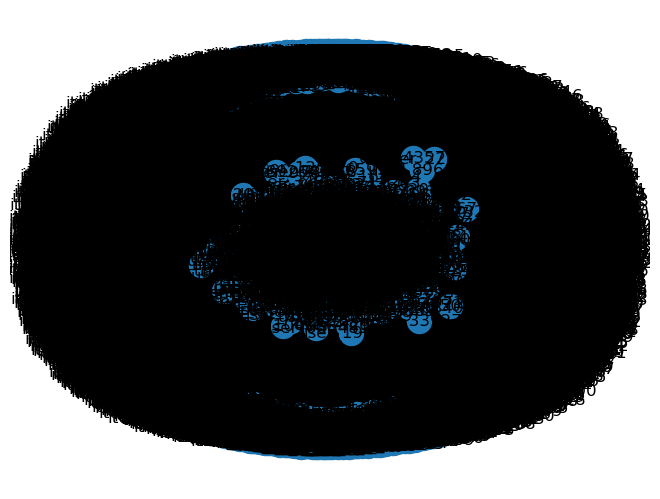

In [4]:
# Draw the graph
nx.draw(G, with_labels=True)
plt.show()

In [53]:
def graph_to_dict(graph):
    user_nodes = [n for n, d in G.nodes(data=True) if d.get('gender') is not None]
    item_nodes = [n for n, d in G.nodes(data=True) if d.get('category') is not None]
    user_map = {n: i for i, n in enumerate(user_nodes)}
    item_map = {n: i for i, n in enumerate(item_nodes)}
    data = {}
    for u, v in graph.edges():
        if u in user_map and v in item_map:
            u_id = user_map[u]
            v_id = item_map[v]
            if u_id not in data:
                data[u_id] = []
            data[u_id].append(v_id)
    for u in data:
        data[u] = np.array(list(set(data[u])))
    return data

In [100]:
import networkx as nx
from recommenders.models.deeprec.models.graphrec.lightgcn import LightGCN
from recommenders.models.deeprec.DataModel.ImplicitCF import ImplicitCF
from recommenders import utils


# Load your graph dataset using NetworkX
graph = nx.read_graphml('ctr_data_1m.graphml')

# Convert the graph to a dictionary of user-item interactions
data = nx.to_dict_of_dicts(graph)

# Split the data into training and validation sets
#train, val = utils.train_test_split(data)

# Build the data model
#train_model = ImplicitCF(train)

# Build the LightGCN model
#model = LightGCN(train_model)

# Train the model
#model.fit(train, n_epochs=10, batch_size=1024)

# Evaluate the model on the validation set
#val_auc = model.evaluate(val)
#print("Validation AUC: {:.4f}".format(val_auc))
# Print the first 10 user-item pairs with their corresponding edge attributes
count = 0
data['432324']

{'1377452': {'click': 0, 'follow': 0, 'like': 0, 'share': 0},
 '16577': {'hist_interaction': 1},
 '4931': {'hist_interaction': 2},
 '12575': {'hist_interaction': 3},
 '314542': {'hist_interaction': 4},
 '9599': {'hist_interaction': 5},
 '24343': {'hist_interaction': 6},
 '13469': {'hist_interaction': 7},
 '23695': {'hist_interaction': 8},
 '59227': {'hist_interaction': 9},
 '9077': {'hist_interaction': 10}}

In [72]:
# Print some basic information about the graph
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Node attributes:", G.nodes['user_432324'])
print("Edge attributes:", G['user_469108']['item_3036331'])

Number of nodes: 8805
Number of edges: 10940
Node attributes: {'gender': 1, 'age': 3}
Edge attributes: {'click': 1, 'follow': 0, 'like': 0, 'share': 0}


In [6]:
from torch_geometric.utils import from_networkx

data = from_networkx(G)

ValueError: Not all nodes contain the same attributes

In [162]:
node_attrs = nx.get_node_attributes(G, 'age')
print(node_attrs)

{'user_432324': 3, 'user_469108': 3, 'user_226641': 0, 'user_371872': 2, 'user_284229': 3, 'user_576428': 4, 'user_505486': 2, 'user_198381': 1, 'user_176742': 2, 'user_486284': 2, 'user_178194': 2, 'user_252151': 0, 'user_705815': 4, 'user_586143': 2, 'user_297434': 0, 'user_226771': 1, 'user_942373': 3, 'user_393165': 2, 'user_264787': 2, 'user_698156': 2, 'user_319335': 2, 'user_233024': 0, 'user_501780': 2, 'user_620657': 2, 'user_146749': 2, 'user_35436': 4, 'user_414071': 4, 'user_231551': 4, 'user_109597': 2, 'user_182589': 2, 'user_371830': 1, 'user_94927': 2, 'user_213519': 0, 'user_446514': 3, 'user_809920': 0, 'user_96103': 3, 'user_402637': 0, 'user_8397': 0, 'user_487833': 4, 'user_575956': 5, 'user_387109': 2, 'user_73566': 3, 'user_945174': 0, 'user_78767': 3, 'user_908851': 0, 'user_379534': 4, 'user_341988': 3, 'user_409322': 4, 'user_424741': 1, 'user_550903': 0, 'user_74637': 2, 'user_151283': 0, 'user_385087': 2, 'user_127974': 0, 'user_211393': 0, 'user_370774': 3,

In [45]:
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout
from tensorflow.keras.models import Model

class MultiTaskLightGCN:
    def __init__(self, num_factors, num_layers, num_tasks):
        self.num_factors = num_factors
        self.num_layers = num_layers
        self.num_tasks = num_tasks
        self.user_embedding = None
        self.item_embedding = None
        self.user_dropout = None
        self.item_dropout = None
        self.user_input = None
        self.item_input = None
        self.task_inputs = None
        self.task_outputs = None
        self.model = None

    def build(self, num_users, num_items):
        # Build the user embedding layer
        self.user_input = Input(shape=(64,), dtype='int32', name='user_input')
        self.user_embedding = Embedding(
            input_dim=num_users,
            output_dim=self.num_factors,
            name='user_embedding',
        )(self.user_input)
        self.user_dropout = Dropout(0.25)(self.user_embedding)

        # Build the item embedding layer
        self.item_input = Input(shape=(64,), dtype='int32', name='item_input')
        self.item_embedding = Embedding(
            input_dim=num_items,
            output_dim=self.num_factors,
            name='item_embedding',
        )(self.item_input)
        self.item_dropout = Dropout(0.25)(self.item_embedding)

        # Build the task-specific output layers
        self.task_inputs = [
            Input(shape=(1,), dtype='float32', name=f'task_{i}_input')
            for i in range(self.num_tasks)
        ]
        self.task_outputs = [
            Dense(units=1, activation='sigmoid', name=f'task_{i}_output')(self.user_dropout if i == 0 else self.item_dropout)
            for i in range(self.num_tasks)
        ]

        # Build the model
        inputs = [self.user_input, self.item_input] + self.task_inputs
        outputs = self.task_outputs
        self.model = Model(inputs=inputs, outputs=outputs)

    def compile(self, optimizer='adam', loss='binary_crossentropy', metrics=None):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def fit(self, feedback_matrices, user_features, item_features, validation_data=None, **kwargs):
        # Convert the feedback matrices to sparse tensors
        feedback_tensors = []
        for i in range(self.num_tasks):
            matrix = feedback_matrices[i]
            indices = matrix.indices
            num_nonzero = matrix.nnz
            # Concatenate the indices array with column indices
            indices = np.concatenate((indices.reshape(-1, 1), np.arange(matrix.shape[1])[None, :].repeat(num_nonzero, axis=0)), axis=1)
            values = matrix.data.astype('float32')
            tensor = tf.sparse.SparseTensor(indices=indices, values=values, dense_shape=matrix.shape)
            feedback_tensors.append(tensor)

        # Fit the model
        self.model.fit(
            [user_features[:, np.newaxis], item_features[:, np.newaxis]] + feedback_tensors,
            validation_data=validation_data,
            **kwargs
        )

    def predict(self, feedback_matrices, user_features, item_features):
        # Convert the feedback matrices to sparse tensors
        feedback_tensors = [
            tf.sparse.SparseTensor(
                indices=feedback_matrices[i].indices,
                values=feedback_matrices[i].data.astype('float32'),
                dense_shape=feedback_matrices[i].shape
            )
            for i in range(self.num_tasks)
        ]

        # Predict the task-specific outputs
        task_outputs = self.model.predict([user_features[:, np.newaxis], item_features[:, np.newaxis]] + feedback_tensors)

        # Convert the task-specific outputs to dense matrices
        output_matrices = [
            sparse.csr_matrix(task_outputs[i].flatten())
            for i in range(self.num_tasks)
        ]

        return output_matrices

In [19]:
import networkx as nx
import numpy as np
import scipy.sparse as sp
from sklearn.model_selection import train_test_split

# Load the graph from the GraphML file
G = nx.read_graphml('ctr_data_1m.graphml')

# Infer the bipartite structure of the graph based on the node attributes
user_nodes = [n for n, d in G.nodes(data=True) if d.get('gender') is not None]
item_nodes = [n for n, d in G.nodes(data=True) if d.get('category') is not None]

# Extract the user and item features from the node attributes
user_features = np.array([np.array([d['age'], d['gender']]) for n, d in G.nodes(data=True) if n in user_nodes])
item_features = np.array([np.array([d['category']]) for n, d in G.nodes(data=True) if n in item_nodes])

# Extract the interaction edges and their corresponding edge features
edges = [(u, v, {'like': G.edges('like'), 'click': G.edges('click'), 'follow': G.edges('follow'), 'share': G.edges('share'), 'watching_times': G.edges('watching_times')}) for u, v, d in G.edges(data=True) if u in user_nodes and v in item_nodes]
interaction_matrix = sp.csr_matrix((np.array([G.edges('like') + G.edges('click') for _, _, d in edges]), (np.array([user_nodes.index(u) for u, _ in edges]), np.array([item_nodes.index(v) for _, v in edges]))), shape=(len(user_nodes), len(item_nodes)))

# Split the interaction matrix into training and test sets
train_indices, test_indices = train_test_split(np.arange(interaction_matrix.shape[0]), test_size=0.2, random_state=42)
train_interaction_matrix = interaction_matrix[train_indices, :]
test_interaction_matrix = interaction_matrix[test_indices, :]


TypeError: unsupported operand type(s) for +: 'EdgeDataView' and 'EdgeDataView'

In [91]:
# Set up the hyperparameter grid
hyperparameters = {
    'embedding_dim': [16, 32, 64],
    'dropout': [0.0, 0.2, 0.4],
    'num_layers': [2, 3, 4],
    'lr': [0.001, 0.01, 0.1],
    'batch_size': [256, 512, 1024]
    'epochs': [10, 20, 30]
}

In [101]:
# Set up the model
yaml_file = 'lightgcn.yaml' # this file is provided by microsoft's recommenders package and it contains the hyperparameters necessary for lightgcn
hparams = prepare_hparams(yaml_file)
model = LightGCN(hparams=hparams, data=train_data)

# Set up the grid search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Run the grid search
grid_search.fit(train_data)

AttributeError: 'DataFrame' object has no attribute 'get_norm_adj_mat'

In [ ]:
# Print the best hyperparameters and the corresponding scores
best_params, best_score = grid_search.best_params_, np.sqrt(-grid_search.best_score_)
print('Best hyperparameters:', best_params)
print('Best score:', best_score)

In [94]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dot, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


# Encode user and item IDs as zero-indexed consecutive integers
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

df['user_id'] = user_encoder.fit_transform(df['user_id'])
df['item_id'] = item_encoder.fit_transform(df['item_id'])

# Define the number of users and items
num_users = df['user_id'].nunique()
num_items = df['item_id'].nunique()

# Create sparse matrices for user-item interactions and other features
clicks_matrix = csr_matrix((df['click'].values, (df['user_id'].values, df['item_id'].values)), shape=(num_users, num_items))
likes_matrix = csr_matrix((df['like'].values, (df['user_id'].values, df['item_id'].values)), shape=(num_users, num_items))
user_features = df[['gender', 'age', 'hist_1', 'hist_2', 'hist_3', 'hist_4', 'hist_5', 'hist_6', 'hist_7', 'hist_8', 'hist_9', 'hist_10']].values
item_features = df[['video_category', 'watching_times']].values

# Define the LightGCN Model
def create_lightgcn_model(num_users, num_items, embedding_size):
    user_input = tf.keras.layers.Input(shape=(1,))
    item_input = tf.keras.layers.Input(shape=(1,))

    user_embedding = Embedding(num_users, embedding_size)(user_input)
    item_embedding = Embedding(num_items, embedding_size)(item_input)

    interaction = Dot(axes=2)([user_embedding, item_embedding])

    model = Model(inputs=[user_input, item_input], outputs=interaction)
    return model

# Define the MTL LightGCN Model
def create_mtl_lightgcn_model(num_users, num_items, embedding_size):
    # Create LightGCN model for shared user-item embeddings
    lightgcn_model = create_lightgcn_model(num_users, num_items, embedding_size)

    # Prediction branch for 'likes'
    likes_prediction = Dense(1, activation='sigmoid', name='likes')(lightgcn_model.output)

    # Prediction branch for 'clicks'
    clicks_prediction = Dense(1, activation='sigmoid', name='clicks')(lightgcn_model.output)

    # Combine the branches
    mtl_model = Model(inputs=lightgcn_model.input, outputs=[likes_prediction, clicks_prediction])

    return mtl_model

# Train the MTL Model
# Train the MTL Model
# Train the MTL Model
def train_mtl_model(mtl_model, clicks_matrix, likes_matrix, user_features, item_features, epochs, batch_size):
    # Compile the model with appropriate losses and metrics for both tasks
    mtl_model.compile(optimizer=Adam(), loss=['binary_crossentropy', 'binary_crossentropy'], metrics=['accuracy'])

    # Train-test split
    clicks_train, clicks_test, likes_train, likes_test, user_features_train, user_features_test, item_features_train, item_features_test = train_test_split(
        clicks_matrix, likes_matrix, user_features, item_features, test_size=0.2, random_state=42
    )

    # Prepare data for both tasks
    user_ids, item_ids = clicks_train.nonzero()

    # Train the model
    mtl_model.fit(
        [user_ids, item_ids],
        [likes_train.data, clicks_train.data],
        validation_data=([likes_test.nonzero()[0], likes_test.nonzero()[1]], [likes_test.data, clicks_test.data]),
        epochs=epochs,
        batch_size=batch_size
    )










# Create and train the MTL LightGCN model
embedding_size = 64
epochs = 10
batch_size = 256

mtl_model = create_mtl_lightgcn_model(num_users, num_items, embedding_size)
train_mtl_model(mtl_model, clicks_matrix, likes_matrix, user_features, item_features, epochs, batch_size)

# Create and train the MTL LightGCN model
embedding_size = 64
epochs = 10
batch_size = 256

mtl_model = create_mtl_lightgcn_model(num_users, num_items, embedding_size)
train_mtl_model(mtl_model, clicks_matrix, likes_matrix, user_features, item_features, epochs, batch_size)

# Create and train the MTL LightGCN model
embedding_size = 64
epochs = 10
batch_size = 256

mtl_model = create_mtl_lightgcn_model(num_users, num_items, embedding_size)
train_mtl_model(mtl_model, clicks_matrix, likes_matrix, user_features, item_features, epochs, batch_size)

# Evaluate the MTL Model (You need test data to evaluate the model)

# To evaluate, you can split your dataset into train, validation, and test sets.
# Then create sparse matrices for the test sets similar to clicks_matrix and likes_matrix.

# For example, if you have test_data_likes and test_data_clicks as sparse matrices:
# test_data_likes and test_data_clicks should be prepared similar to the train data.

test_loss, test_likes_loss, test_clicks


ValueError: Input arrays should have the same number of samples as target arrays. Found 189 input samples and 800 target samples.

In [95]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, DictVectorizer
from scipy.sparse import csr_matrix
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from recommenders.feature import SparseFeat, VarLenSparseFeat
from recommenders.models import LightGCN
from recommenders.losses import weighted_binary_crossentropy



train, val, test = np.split(df.sample(frac=1, random_state=42), [int(0.7*len(data)), int(0.85*len(data))])

# Create the sparse user-item interaction matrix
sparse_features = ['user_id', 'item_id']
varlen_sparse_features = ['hist_1', 'hist_2', 'hist_3', 'hist_4', 'hist_5', 'hist_6', 'hist_7', 'hist_8', 'hist_9', 'hist_10']
feature_columns = [SparseFeat(feat, data[feat].nunique(), embedding_dim=16) for feat in sparse_features] + [VarLenSparseFeat(feat, data[feat].nunique(), maxlen=10, embedding_dim=16) for feat in varlen_sparse_features]
feature_inputs = {feat: Input(shape=(1,), name=feat) for feat in sparse_features} 
feature_inputs.update({feat: Input(shape=(10,), name=feat) for feat in varlen_sparse_features})
data['gender'] = OneHotEncoder().fit_transform(data['gender'].values.reshape(-1, 1)).toarray()
dict_data = data[feature_columns + ['gender']].to_dict(orient='records')
dict_vec = DictVectorizer()
sparse_data = dict_vec.fit_transform(dict_data)
user_item_matrix = csr_matrix((data['click'].values.astype(np.float32), (data['user_id'], data['item_id'])))

# Define the MTL LightGCN model
num_tasks = 2
num_layers = 3
embedding_dim = 32
dropout = 0.5
lightgcn = LightGCN(user_item_matrix, embedding_dim=embedding_dim, num_layers=num_layers, dropout=dropout, use_bias=False, num_tasks=num_tasks)
output_layers = [Dense(1, activation='sigmoid') for _ in range(num_tasks)]
inputs = [feature_inputs[feat] for feat in sparse_features + varlen_sparse_features]
outputs = [output_layers[i](lightgcn(inputs[:-1], i)) for i in range(num_tasks)]
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss=weighted_binary_crossentropy([0.5, 0.5]))

ImportError: cannot import name 'DictVectorizer' from 'sklearn.preprocessing' (/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/__init__.py)